In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
from skimage import exposure
from operator import itemgetter
import cv2

In [14]:
clinical_data = pd.read_csv('data_with_inverted_columns.csv')
data_dir = '../../ai4covid_data'

def load_image(filename):
    return cv2.imread(f'{data_dir}/TrainSet/{filename}', cv2.IMREAD_ANYDEPTH)

def is_inverted(image, corner_ratio=0.2, center_ratio=0.05, bottom=True):
    height, width = image.shape
    corner_size = (int(height*corner_ratio), int(width*corner_ratio))
    tl = image[:corner_size[0], :corner_size[1]].flatten()
    bl = image[-corner_size[0]:, :corner_size[1]].flatten()
    tr = image[:corner_size[0], -corner_size[1]:].flatten()
    br = image[-corner_size[0]:, -corner_size[1]:].flatten()
    if bottom:
        corners = np.hstack([tl, bl, tr, br])
    else:
        corners = np.hstack([tl, tr])
            
    center = image[
        int(height*(0.5-center_ratio)):int(height*(0.5+center_ratio)),
        int(width*(0.5-center_ratio)):int(width*(0.5+center_ratio))
    ]
    return center.mean() < corners.mean()

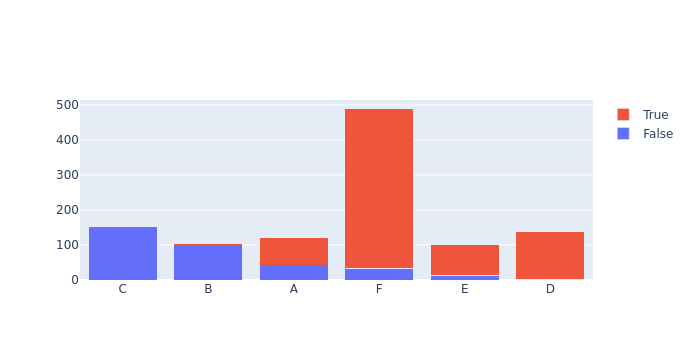

In [8]:
fig = go.Figure()
for inverted, data in clinical_data.groupby('inverted'):
    vc = data.value_counts('Hospital')
    fig.add_trace(go.Bar(
        x=vc.keys(),
        y=vc.values,
        name=bool(inverted)
    ))
fig.update_layout(
    barmode='stack'
)
fig.show()

## testing the inversion detection

In [15]:
accuracy = 0
bad_predictions = []
for idx, data in clinical_data.iterrows():
    image = load_image(data['ImageFile'])
    if is_inverted(image) == data['inverted']:
        accuracy += 1
    else:
        bad_predictions.append(idx)
accuracy /= len(clinical_data)

In [16]:
accuracy

0.9918404351767905

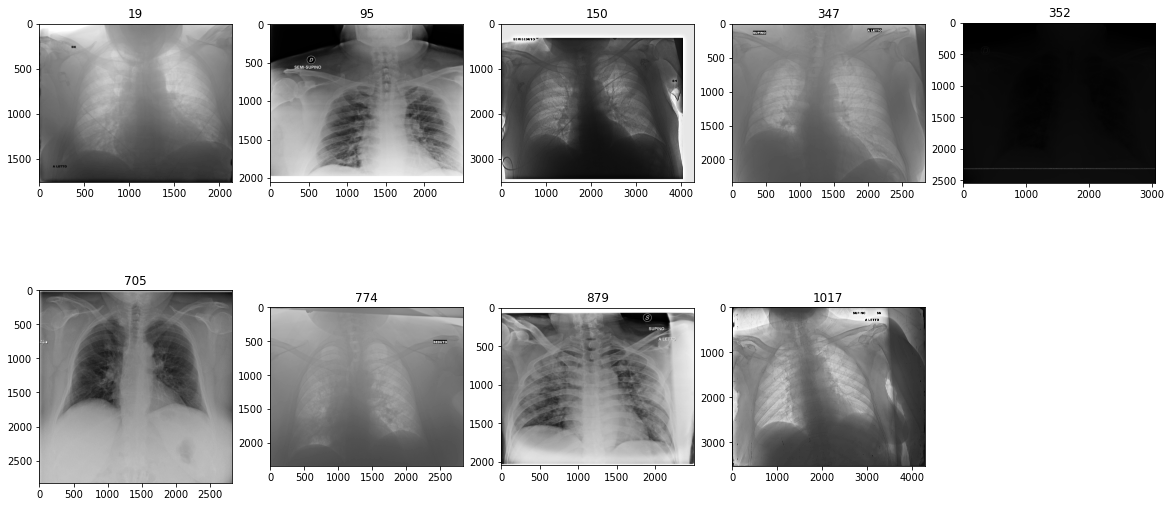

In [19]:
plt.figure(figsize=(20,20))
for fig_idx, (idx, data) in enumerate(clinical_data.iloc[bad_predictions].iterrows()):
    image = load_image(data['ImageFile'])
    plt.subplot(4, 5, fig_idx+1)
    plt.title(idx)
    plt.imshow(image, 'gray')